# Load Required Libraries

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

# Data Preparation



In [ ]:
from keras.datasets import mnist

# load data already split into training and test set
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
# flatten the 3D data set to a 2D data set by making 28x28
# elements into a 784 element array
x_train_flat = []
for img in x_train:
    tmp = []
    for x in img:
        tmp += list(x)
    x_train_flat += [tmp]
# replicate for test set
x_test_flat = []
for img in x_test:
    tmp = []
    for x in img:
        tmp += list(x)
    x_test_flat += [tmp]

In [ ]:
# change list to numpy array
x_train = np.array(x_train_flat)
x_test = np.array(x_test_flat)

In [ ]:
# reshape y_train and y_test array from 1D to 2D and then 
# encode y_train and y_test to a onehotencoded arrays of 0 
# and 1 of length 10
enc = OneHotEncoder()
enc.fit(y_train.reshape((-1, 1)))
y_train = enc.transform(y_train.reshape((-1, 1))).toarray()
enc.fit(y_test.reshape((-1, 1)))
y_test = enc.transform(y_test.reshape((-1, 1))).toarray()

# Helper Functions

### Generate Shapes and Initial Weights and Bias

In [ ]:
# function to generate shapes array for generating correct shaped
# weights and bias x, then hidden layer units, then y
def generateShapesArray (x, hidden_layers, y):
    # number of features in input layer are added to shapes
    shapes = [x.shape[1]]
    
    # for each item in hidden layers list, add number of hidden 
    # units to shapes
    for layer in range(len(hidden_layers)):
        shapes += [hidden_layers[layer]]
    
    # number of labels in output layer are added to shapes
    shapes += [y.shape[1]]
    
    return shapes

# function to generate initial dictionaries to store weights and 
# bias through the use of a dictionary 
def generateInitialWB (layers, shapes):
    # initialize 2 dictionaries
    weights_dict, bias_dict = {}, {}
    
    np.random.seed(42)

    # for each weight and bias layer (input to h1, h1 to h2, so on)
    # generate weights randomly between -0.01 and 0.01, and biases as 0
    for i in range(layers + 1):
        # generate a key, e.g. w1, w2, etc. for easier referencing
        w_key, b_key = "w" + str(i + 1), "b" + str(i + 1)
        w, b = np.random.uniform(-0.01, 0.01, size = (shapes[i], shapes[i + 1])), 0
        # add to dictionaries
        weights_dict[w_key], bias_dict[b_key] = w, b
    
    return weights_dict, bias_dict

### Activation Functions

In [ ]:
# z = wTx+b --> relu = max(0, z)
# used for every layer except output layer
def reluForward (x, w, b):
    z = np.matmul(x, w) + b
    return np.maximum(0, z)

# z = wTx+b --> softmax = e^z / sum(e^z)
# used for output layer only
def softmaxForward (x, w, b):
    z = np.matmul(x, w) + b
    return np.exp(z) / np.exp(z).sum(1, keepdims = True)

### Loss Function

In [ ]:
# loss function across all data points
# mean of cost = loss = average(-y * log(a))
def calculateLoss (a, y):
    return (-np.sum(np.multiply(y, np.log(a))) / y.shape[0])

### Forward Propagate

In [ ]:
# function to forward propogate and calculate sum of square weights for 
# regularization term
def forwardPropogate (x, weights_dict, bias_dict, layers):
    # initialive values dictionary to store hidden layer outputs
    # and final layer output
    values_dict = {}
    # initialize regularization term
    r = 0
        
    # for each layer, forward propogate through
    for layer in range(layers + 1):
            
        # generate wights and bias keys using layer number to access
        # weights and bias from the generated dictionaries
        w_key, b_key = "w" + str(layer + 1), "b" + str(layer + 1)
        # access the weights and bias
        w, b = weights_dict[w_key], bias_dict[b_key]
            
        # add the sum of square weights into the regularization term
        # to add to the loss function
        r += np.sum(np.square(w))
            
        # generate a_key using layer number to store and allow for future
        # access of the hidden layer and output layer outputs
        a_key = "a" + str(layer + 1)
        a_key_p = "a" + str(layer)
        # if first layer needs to be calculated, relu is called using
        # x, weights (w1), and bias (b1)
        if layer == 0:
            a = reluForward (x, w, b)
        # until the final layer needs to be calculated, relu is called
        # using a value from previous layer, weights, and bias
        elif layer != layers:
            a = reluForward (values_dict[a_key_p], w, b)
        # if output layer needs to be calculated, softmax is called using
        # a value from previous layer, weights, and bias
        else:
            a = softmaxForward (values_dict[a_key_p], w, b)
        # store output a using generated a_key in values_dict
        values_dict[a_key] = a
    
    return values_dict, r

### Back Propagate

In [ ]:
# function to back propogate and calculate gradients for weights and bias for
# all layers
def backPropogate (values_dict, weights_dict, x, y, layers):
    # initialize weight and bias gradient dictionaries, and delta dictionary
    # the delta dictionary helps simply gradient calculations as future layer
    # delta is used in current layer gradient calculation
    w_gradient_dict, b_gradient_dict, delta_dict = {}, {}, {}
    
    # for each layer, back propogate from output layer to input layer
    for back_step in range(layers + 1):
        # use iteration number to calculate gradient number from last element, i.e.
        # going backwards
        # e.g. iteration 1 --> wg(3 hidden layers + 1 - 0) --> wg4
        # wg4 would be used to update w4 --> weight between h3 and output
        wg_key, bg_key = "w" + str(layers + 1 - back_step), "b" + str(layers + 1 - back_step)
        
        # generate necessary keys to access dictionary values for gradient 
        # calculations
        w_key = "w" + str(layers + 1 - back_step) # current layer weight
        w_key_n = "w" + str(layers + 2 - back_step) # future layer weight
        a_key = "a" + str(layers + 1 - back_step) # current layer values
        a_key_p = "a" + str(layers - back_step) # previous layer values
        d_key = "d" + str(layers + 1 - back_step) # current layer delta
        d_key_n = "d" + str(layers + 2 - back_step) # future layer delta
        
        # if first back propogation iteration, output layer weights and bias update
        if back_step == 0:
            # A - y
            delta_dict[d_key] = values_dict[a_key] - y
            # delta value . output value of previous layer / m
            w_gradient_dict[wg_key] = np.matmul(values_dict[a_key_p].T, delta_dict[d_key]) / x.shape[0]
            # delta value / m
            b_gradient_dict[bg_key] = np.sum(delta_dict[d_key]) / x.shape[0]
        # if last back propogation step, input layer weights and bias update
        elif layers - back_step == 0:
            # future layer delta . future layer weights * derivative of relu
            delta_dict[d_key] = np.matmul(delta_dict[d_key_n], weights_dict[w_key_n].T) * np.where(values_dict[a_key] > 0, 1, 0)
            # x . delta value / m
            # x is the difference between updating input layer vs update other hidden layers
            w_gradient_dict[wg_key] = np.matmul(x.T, delta_dict[d_key]) / x.shape[0]
            # delta value / m
            b_gradient_dict[bg_key] = np.sum(delta_dict[d_key]) / x.shape[0]
        # if hidden layer back propogation
        else:
            # future layer delta . future layer weights * derivative of relu
            delta_dict[d_key] = np.matmul(delta_dict[d_key_n], weights_dict[w_key_n].T) * np.where(values_dict[a_key] > 0, 1, 0)
            # previous layer values . delta value / m
            w_gradient_dict[wg_key] = np.matmul(values_dict[a_key_p].T, delta_dict[d_key]) / x.shape[0]
            # delta value / m
            b_gradient_dict[bg_key] = np.sum(delta_dict[d_key]) / x.shape[0]

    return w_gradient_dict, b_gradient_dict

### Update Weights

In [ ]:
# function to update weights and bias values for all layers using gradients,
# alpha, and regularization lambda term
def updateWeights (weights_dict, bias_dict, w_gradient_dict, b_gradient_dict, alpha, layers ,l):
    weights_dict_updated, bias_dict_updated = {}, {}
    
    # for each layer, update weights and bias
    for layer in range(layers + 1):
        # generate weights, bias, weight gradient, and bias gradient keys to access
        # the respective values in the dictionaries
        # w_key and wg_key are the same, but for completeness both are generated
        w_key, b_key = "w" + str(layer + 1), "b" + str(layer + 1)
        wg_key, bg_key = "w" + str(layer + 1), "b" + str(layer + 1)
        
        # update weights using gradients and regularization lambda term and overwrite
        # in the dictionary
        weights_dict_updated[w_key] = ((1 - ((alpha * l) / x.shape[0])) * weights_dict[w_key]) - (alpha * w_gradient_dict[wg_key])
        bias_dict_updated[b_key] = bias_dict[b_key] - (alpha * b_gradient_dict[bg_key])

    return weights_dict_updated, bias_dict_updated

### Calcualte Accuracy

In [ ]:
# function to calculate accuracy
def calculateAccuracy (output, y):
  # initialize
  correct_predictions = 0

  # for each predicted label, compare against actual label
  for i in range(len(output)):
    if output[i].argmax() == y[i].argmax():
      correct_predictions += 1

  # calculate accuracy
  accuracy = correct_predictions / len(output)

  return accuracy

# Train Function

In [ ]:
def trainNeuralNetwork (x, y, max_iter = 1000, alpha = 0.01, hidden_layers = [5, 6, 7], l = 0):
    # number of layers stored to use for iterating
    layers = len(hidden_layers)
    
    # using helper to generate shapes array
    shapes = generateShapesArray(x, hidden_layers, y)

    # using helper to generate initial weights and biases
    weights_dict, bias_dict = generateInitialWB (layers, shapes)
    
    # initialize list to store loss
    loss = []
    
    # loop through number of iterations passed through parameters
    for iteration in range(max_iter):
        
        # using helper function to generate output values of each hidden layer,
        # output layer and regularization sum of squared weights
        values_dict, r = forwardPropogate (x, weights_dict, bias_dict, layers)
        
        # use lambda parameter to complete regularization term calculation
        # sum(weights) * lambda/2m
        r = r * (l / (2 * x.shape[0]))
        
        # generate output a_key to access the output from values_dict
        last_a_key = "a" + str(layers + 1)
        # using helper function to generate loss and add calculated regularization
        # term
        loss += [calculateLoss(values_dict[last_a_key], y) + r]
        
        # using helper function to generate gradients for each layer and storing in 
        # a dictionary similar to weights, bias, and output values
        w_gradient_dict, b_gradient_dict = backPropogate(values_dict, weights_dict, x, y, layers)

        # using helper function to update weights using gradients, learning rate, and 
        # regularization lambda term
        weights_dict, bias_dict = updateWeights(weights_dict, bias_dict, w_gradient_dict, b_gradient_dict, alpha, layers, l)
    
    # store output layer
    output = values_dict[last_a_key]
    # use helper function with output layer and actual labels to calculate accuracy
    accuracy = calculateAccuracy(output, y)

    return weights_dict, bias_dict, loss, accuracy

In [ ]:
# making sure that the training function is working as expected
weights, bias, loss, accuracy = trainNeuralNetwork(x_train, y_train, max_iter = 100, alpha = 0.01, hidden_layers = [128, 128])
loss[-1], accuracy

(0.35535686554036905, 0.8933333333333333)

# Test Function

In [ ]:
def testNeuralNetwork (x, y, weights_dict, bias_dict):
    # initialize values dictionary to store outputs of each layer
    values_dict = {}
    
    # for each layer, access weights and bias from dictionary and 
    # call appropriate activation function to calculate output 
    for layer in range(len(weights_dict.items())):
        # generate wights and bias keys using layer number to access
        # weights and bias from the generated dictionaries
        w_key, b_key = "w" + str(layer + 1), "b" + str(layer + 1)
        # access the weights and bias
        w, b = weights_dict[w_key], bias_dict[b_key]
        
        # generate a_key using layer number to store and allow for future
        # access of the hidden layer and output layer outputs
        a_key = "a" + str(layer + 1)
        # if first layer needs to be calculated, relu is called using
        # x, weights (w1), and bias (b1)
        if layer == 0:
            a = reluForward (x, w, b)
        # until the final layer needs to be calculated, relu is called
        # using a value from previous layer, weights, and bias
        elif layer != len(weights_dict.items()) - 1:
            a = reluForward (a, w, b)
        # if output layer needs to be calculated, softmax is called using
        # a value from previous layer, weights, and bias
        else:
            a = softmaxForward (a, w, b)
        
        # store output a using generated a_key in values_dict    
        values_dict[a_key] = a
    
    # generate output a_key to access the output from values_dict
    last_a_key = "a" + str(len(weights_dict.items()))
    # using helper function to generate loss and add calculated regularization term
    loss = calculateLoss(values_dict[last_a_key], y)
    #  use helper function with output layer and actual labels to calculate accuracy
    accuracy = calculateAccuracy(values_dict[last_a_key], y)

    return loss, accuracy

In [ ]:
# making sure that the test function is working as expected
loss, accruacy = testNeuralNetwork(x_test, y_test, weights, bias)
loss, accuracy

(0.33575045469595943, 0.8933333333333333)

# Hyperparameter Tuning

### Tune Layers

In [ ]:
# running with 250 iterations to see fastest learners.

def tuneLayers (x_train, x_test, y_train, y_test):
    # initialize lists to store values
    training_loss = []
    training_accuracy = []
    validation_loss = []
    validation_accuracy = []

    # use layers used above and add more layer sets in a list to test
    layers_test = [[128, 128], [128, 128, 128], [128, 128, 128, 128], [128, 128, 128, 128, 128]]

    # for each element in the layers_test set
    for i in range(len(layers_test)):

        # train model with 50 iterations
        weights, bias, loss, accuracy = trainNeuralNetwork(x_train, y_train, max_iter = 250, hidden_layers = layers_test[i])
        # store loss and accuracy
        training_loss += [loss]
        training_accuracy += [accuracy]

        # validate model using test set
        loss, accruacy = testNeuralNetwork(x_test, y_test, weights, bias)
        # store loss and accuracy
        validation_loss += [loss]
        validation_accuracy += [accuracy]
    
    # find the best layer set using maximum validation accuracy
    best_idx = validation_accuracy.index(max(validation_accuracy))

    return layers_test[best_idx], training_loss, training_accuracy, validation_loss, validation_accuracy

In [ ]:
best_layers, train_loss, train_acc, val_loss, val_acc = tuneLayers(x_train, x_test, y_train, y_test)
best_layers

[128, 128]

<Figure size 432x288 with 0 Axes>

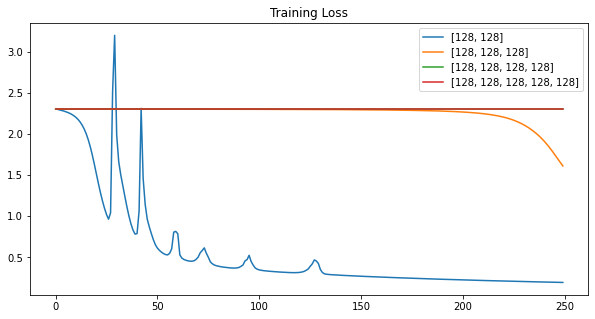

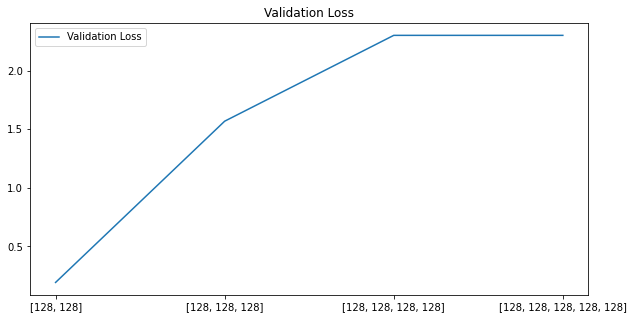

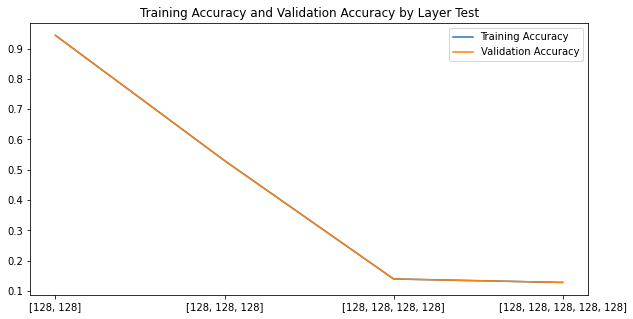

In [ ]:
layer_test = ["[128, 128]", "[128, 128, 128]", "[128, 128, 128, 128]", "[128, 128, 128, 128, 128]"]
plot1 = plt.figure(1)
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(list(range(len(train_loss[0]))), train_loss[0])
plt.plot(list(range(len(train_loss[0]))), train_loss[1])
plt.plot(list(range(len(train_loss[0]))), train_loss[2])
plt.plot(list(range(len(train_loss[0]))), train_loss[3])
plt.legend(layer_test)
plot2 = plt.figure(2)
plt.figure(figsize=(10,5))
plt.title("Validation Loss")
plt.plot(layer_test, val_loss)
plt.legend(["Validation Loss"])
plot3 = plt.figure(3)
plt.figure(figsize=(10,5))
plt.title("Training Accuracy and Validation Accuracy by Layer Test")
plt.plot(layer_test, train_acc)
plt.plot(layer_test, val_acc)
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.show()

### Tune Alpha

In [ ]:
# running with 250 iterations to see fastest learners.

def tuneAlpha (x_train, x_test, y_train, y_test, layers):
    # initialize lists to store values
    training_loss = []
    training_accuracy = []
    validation_loss = []
    validation_accuracy = []

    # use alpha used above and add more alpha values in a list to test
    alpha_test = [0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]

    # for each element in the alpha_test set
    for i in range(len(alpha_test)):

        # train model with 50 iterations using the best layer set selected
        weights, bias, loss, accuracy = trainNeuralNetwork(x_train, y_train, max_iter = 250, alpha = alpha_test[i], hidden_layers = layers)
        # store loss and accuracy
        training_loss += [loss]
        training_accuracy += [accuracy]

        # validate model using test set
        loss, accruacy = testNeuralNetwork(x_test, y_test, weights, bias)
        # store loss and accuracy
        validation_loss += [loss]
        validation_accuracy += [accuracy]
    
    # find the best alpha using maximum validation accuracy
    best_idx = validation_accuracy.index(max(validation_accuracy))

    return alpha_test[best_idx], training_loss, training_accuracy, validation_loss, validation_accuracy


In [ ]:
best_alpha, train_loss, train_acc, val_loss, val_acc = tuneAlpha(x_train, x_test, y_train, y_test, best_layers)
best_alpha

0.01

<Figure size 432x288 with 0 Axes>

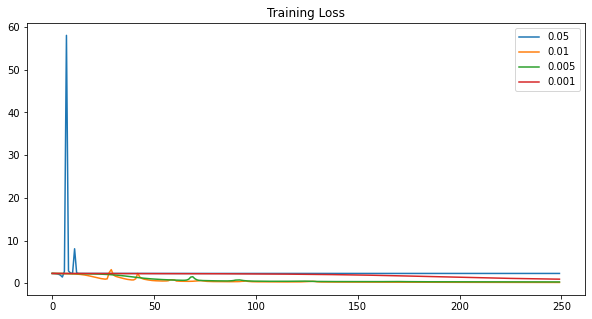

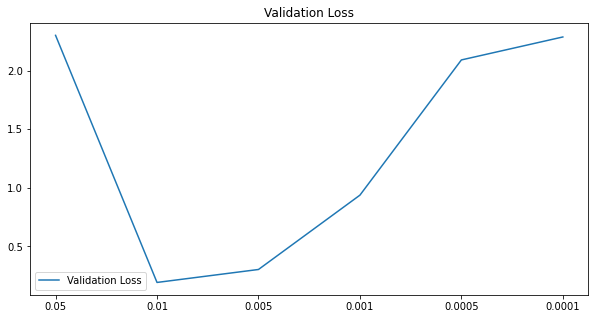

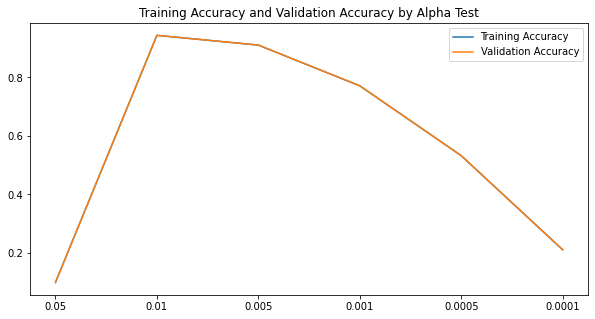

In [ ]:
alpha_test = ["0.05", "0.01", "0.005", "0.001", "0.0005", "0.0001"]
plot1 = plt.figure(1)
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(list(range(len(train_loss[0]))), train_loss[0])
plt.plot(list(range(len(train_loss[0]))), train_loss[1])
plt.plot(list(range(len(train_loss[0]))), train_loss[2])
plt.plot(list(range(len(train_loss[0]))), train_loss[3])
plt.legend(alpha_test)
plot2 = plt.figure(2)
plt.figure(figsize=(10,5))
plt.title("Validation Loss")
plt.plot(alpha_test, val_loss)
plt.legend(["Validation Loss"])
plot3 = plt.figure(3)
plt.figure(figsize=(10,5))
plt.title("Training Accuracy and Validation Accuracy by Alpha Test")
plt.plot(alpha_test, train_acc)
plt.plot(alpha_test, val_acc)
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.show()

### Tune Lambda

In [ ]:
# running with 250 iterations to see fastest learners.

def tuneLambda (x_train, x_test, y_train, y_test, layers, alpha):
    training_loss = []
    training_accuracy = []
    validation_loss = []
    validation_accuracy = []

    # use 0 lambda and add more lambda values in a list to test
    lambda_test = [0, 0.01, 0.001, 0.0001, 0.00001, 0.000001]

    # for each element in the alpha_test set
    for i in range(len(alpha_test)):

        # train model with 50 iterations using the best layer set and best alpha selected
        weights, bias, loss, accuracy = trainNeuralNetwork(x_train, y_train, max_iter = 250, alpha = alpha, hidden_layers = layers, l = lambda_test[i])
        # store loss and accuracy
        training_loss += [loss]
        training_accuracy += [accuracy]

        # validate model using test set
        loss, accruacy = testNeuralNetwork(x_test, y_test, weights, bias)
        # store loss and accuracy
        validation_loss += [loss]
        validation_accuracy += [accuracy]
    
    # find the best alpha using maximum validation accuracy
    best_idx = validation_accuracy.index(max(validation_accuracy))

    return lambda_test[best_idx], training_loss, training_accuracy, validation_loss, validation_accuracy


In [ ]:
best_lambda, train_loss, train_acc, val_loss, val_acc = tuneLambda(x_train, x_test, y_train, y_test, best_layers, best_alpha)
best_lambda

0.01

<Figure size 432x288 with 0 Axes>

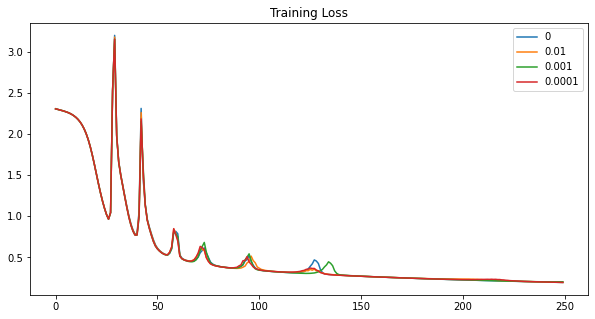

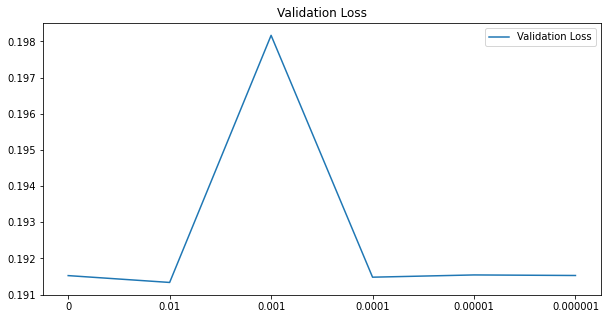

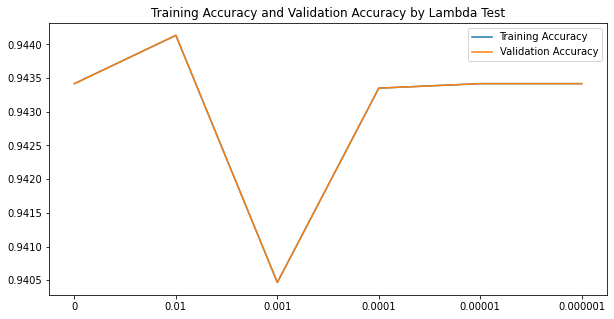

In [ ]:
lambda_test = ["0", "0.01", "0.001", "0.0001", "0.00001", "0.000001"]
plot1 = plt.figure(1)
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(list(range(len(train_loss[0]))), train_loss[0])
plt.plot(list(range(len(train_loss[0]))), train_loss[1])
plt.plot(list(range(len(train_loss[0]))), train_loss[2])
plt.plot(list(range(len(train_loss[0]))), train_loss[3])
plt.legend(lambda_test)
plot2 = plt.figure(2)
plt.figure(figsize=(10,5))
plt.title("Validation Loss")
plt.plot(lambda_test, val_loss)
plt.legend(["Validation Loss"])
plot3 = plt.figure(3)
plt.figure(figsize=(10,5))
plt.title("Training Accuracy and Validation Accuracy by Lambda Test")
plt.plot(lambda_test, train_acc)
plt.plot(lambda_test, val_acc)
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.show()

# Final Model

In [ ]:
# train network with 100 iterations using the best hyperparameters
weights, bias, train_loss, train_accuracy = trainNeuralNetwork(x_train, y_train, max_iter = 1000, alpha = best_alpha, hidden_layers = best_layers, l = best_lambda)
# validated trained network using test set
val_loss, val_accuracy = testNeuralNetwork(x_test, y_test, weights, bias)

<Figure size 432x288 with 0 Axes>

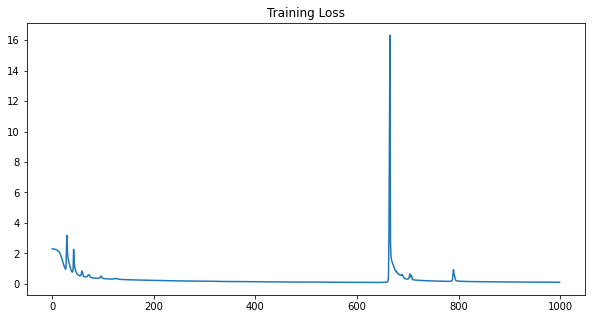

In [ ]:
plot1 = plt.figure(1)
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(list(range(len(train_loss))), train_loss)
plt.show()

In [ ]:
print(f"Training Loss:       {train_loss[-1]}")
print(f"Training Accuracy:   {train_accuracy}")
print(f"Validation Loss:     {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

Training Loss:       0.1080628809100386
Training Accuracy:   0.9685
Validation Loss:     0.12463897294666212
Validation Accuracy: 0.963


In [38]:
min(train_loss)

0.09303578915632811